In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

# Deterministic model

$$
I_{t+1} = I_t + b_t S_t I_t - \gamma I_t \quad (2.2) \\
b_t = b_0 c^*_t \quad (2.4) \\
c^*_t = \hat{c} - \alpha \frac{I_{(t-\Delta)}}{N} \quad (2.10)
$$

$$
I_{t+1} = I_t^2 \big(\frac{b_0 \alpha}{N} I_{(t-\Delta)} - b_0 \hat{c} \big) + I_t (b_0 N \hat{c} -\alpha b_0 I_{(t-\Delta)} + 1 - \gamma) = f(I_t)
\quad (2.11)
$$

$$
\hat{I}_1 = \frac{\alpha +\hat{c} + \sqrt{\alpha^2 + \hat{c}^2 - 2\alpha \hat{c} + 4\frac{\alpha}{b_0 N} \gamma}}{2\frac{\alpha}{N}}
\quad (3.3) \\
\hat{I}_2 = \frac{\alpha +\hat{c} - \sqrt{\alpha^2 + \hat{c}^2 - 2\alpha \hat{c} + 4\frac{\alpha}{b_0 N} \gamma}}{2\frac{\alpha}{N}}
\quad (3.4)
$$

In [2]:
N = 10000
I0 = 1
b0 = 0.05
γ = 0.08
c_hat = 0.0015
α1 = 0.02
α2 = 0.3
Δ = 3

b0s = [0.005, 0.01, 0.03, 0.04, 0.05, 0.1]
Δs = [0, 1, 2, 3]

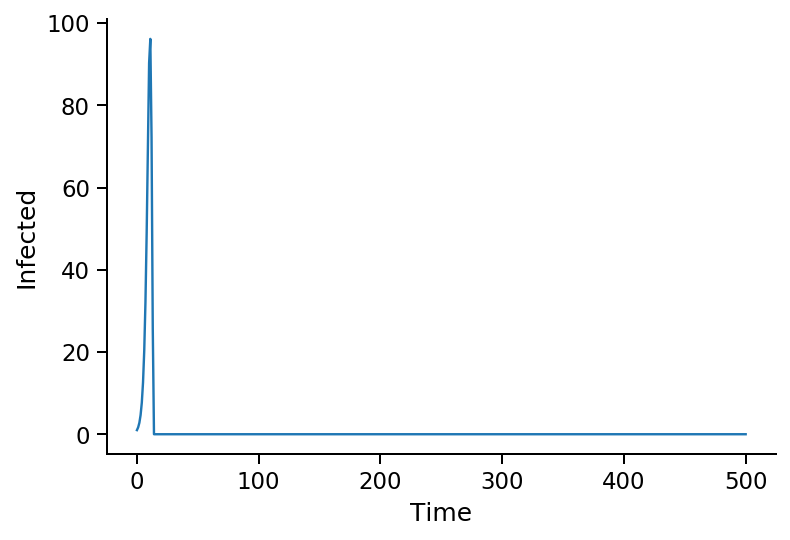

In [3]:
def f(It, IΔ, N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    It1 = It * It * b0 * (α * IΔ / N - c_hat) + It * (b0 * N * c_hat - α * b0 * IΔ + 1 - γ)
    It1 = np.array(It1)
    It1[It1 < 0] = 0
    return It1

def simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500):
    I = np.zeros(tmax+1)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t-Δ >= 0 else 0
        I[t+1] = f(I[t], IΔ, N, b0, γ, c_hat, α1, α2)
    return I

def I2(N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    numer = α + c_hat - np.sqrt(α * α + c_hat * c_hat - 2 * α * c_hat + 4 * α * γ / (b0 * N))
    res = numer / (2 * α / N)
    if res < 0: return np.nan
    return res

I = simulation(I0, N, b0, γ, c_hat, α1, α2, Δ)
plt.plot(I)
plt.xlabel('Time')
plt.ylabel('Infected')
sns.despine()

In [4]:
print("Table 1")
print("b0\tI2")
for b0_ in b0s:
    print("{:.3f}\t{:.3f}".format(b0_, I2(N, b0_, γ, c_hat, α1, α2)))

Table 1
b0	I2
0.005	nan
0.010	92.339
0.030	54.750
0.040	43.304
0.050	35.718
0.100	18.931


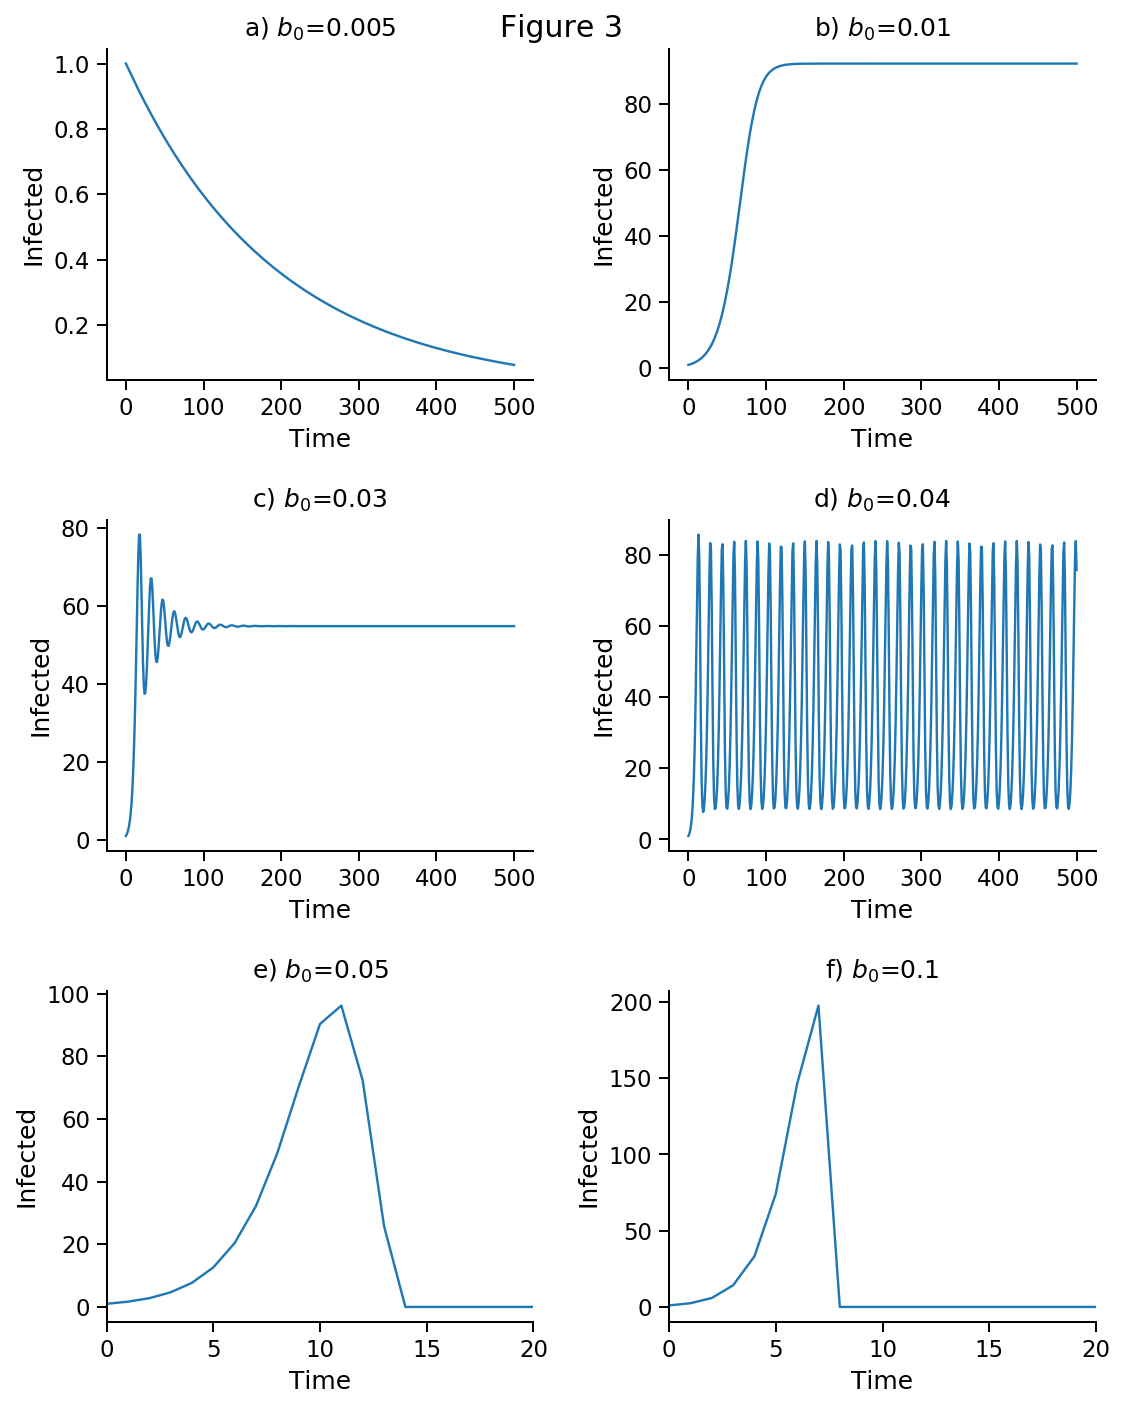

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
for b0_, ax, title in zip(b0s, axes.flat, 'abcdef'):
    I = simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ)
    ax.plot(I)
    ax.set_ylabel('Infected')
    ax.set_xlabel('Time')
    ax.set_title("{}) $b_0$={}".format(title, b0_))
axes[2,0].set_xlim(0, 20)
axes[2,1].set_xlim(0, 20)
plt.suptitle('Figure 3')
fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig3.pdf')

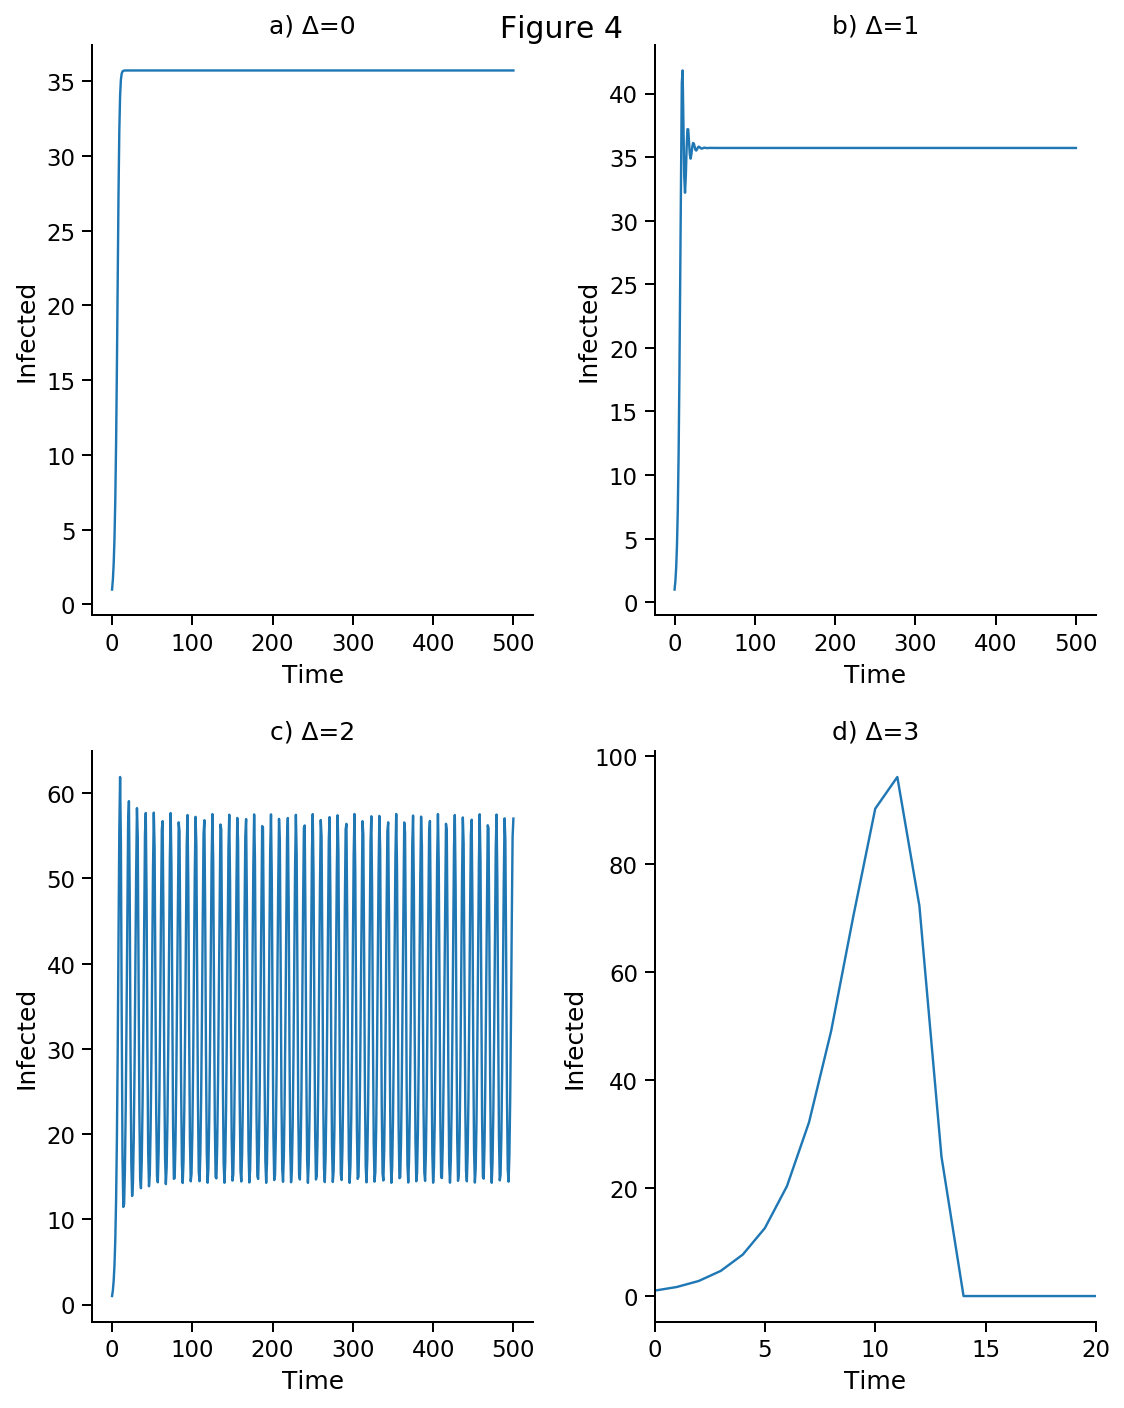

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10))
for Δ_, ax, title in zip(Δs, axes.flat, 'abcdef'):
    I = simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_)
    ax.plot(I)
    ax.set_ylabel('Infected')
    ax.set_xlabel('Time')
    ax.set_title("{}) Δ={}".format(title, Δ_))
axes[1,1].set_xlim(0, 20)
plt.suptitle('Figure 4')
fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig4.pdf')

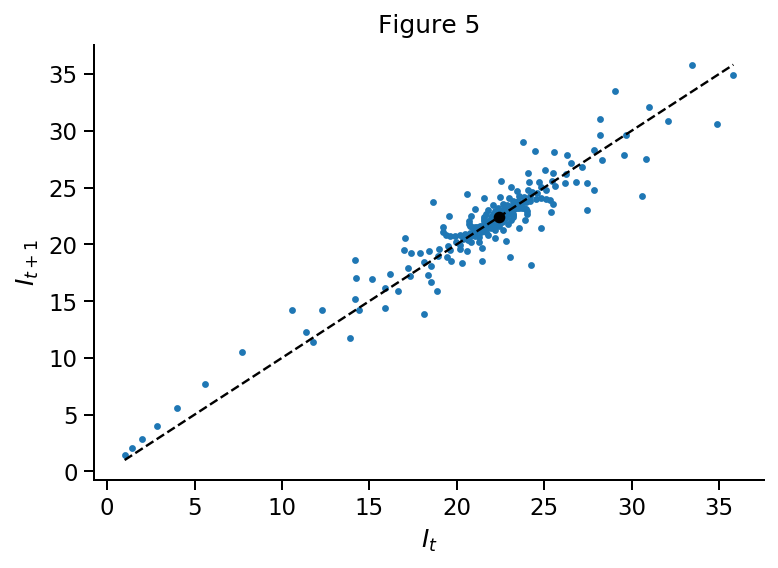

In [7]:
c_hat_ = 0.001

I = simulation(I0, N, b0, γ, c_hat_, α1, α2, Δ)

plt.figure(figsize=(6, 4))
plt.plot(I[:-1], I[1:], '.')
line = np.linspace(I.min(), I.max())
plt.plot(line, line, ls='--', color='k')
plt.plot(I2(N, b0, γ, c_hat_, α1, α2), I2(N, b0, γ, c_hat_, α1, α2), 'ok')
plt.xlabel('$I_t$')
plt.ylabel('$I_{t+1}$')
plt.title('Figure 5')
sns.despine()
plt.savefig('../figures/fig5.pdf')

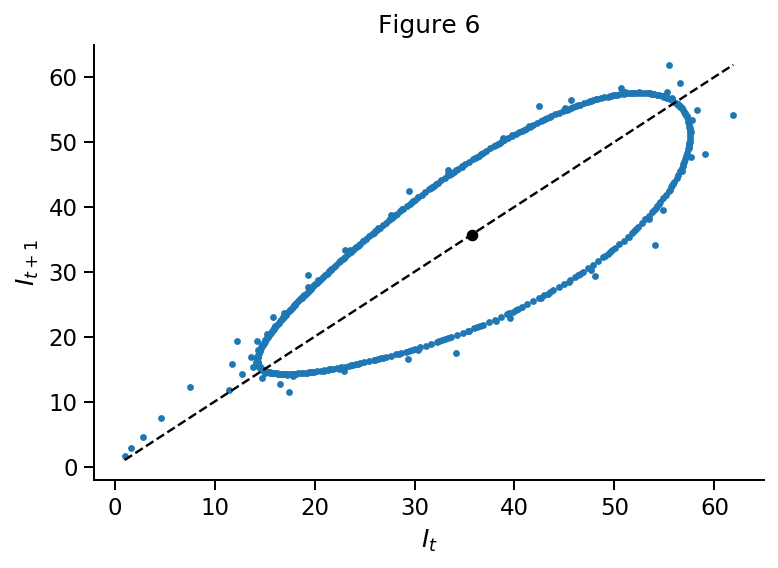

In [8]:
Δ_ = 2

I = simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_)

plt.figure(figsize=(6, 4))
plt.plot(I[:-1], I[1:], '.')
line = np.linspace(I.min(), I.max())
plt.plot(line, line, ls='--', color='k')
plt.plot(I2(N, b0, γ, c_hat, α1, α2), I2(N, b0, γ, c_hat, α1, α2), 'ok')
plt.xlabel('$I_t$')
plt.ylabel('$I_{t+1}$')
plt.title('Figure 6')
sns.despine()
plt.savefig('../figures/fig6.pdf')

# Stochastic model

$$
I_{t+1} = I_t + Poi(b_t S_t I_t) - Poi(\gamma I_t) \\
b_t = b_0 c^*_t \quad (2.4) \\
c^*_t = \hat{c} - \alpha \frac{I_{(t-\Delta)}}{N} \quad (2.10)
$$

In [9]:
# def poi(λ):
#     if λ <= 0: return 0
#     return np.random.poisson(λ)

poi = np.random.poisson

def ssimulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500):
    α = α2 / (2 * α1) * b0
    I = np.zeros(tmax+1, dtype=int)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t-Δ >= 0 else 0
        bt = max(0, b0 * c_hat - α * IΔ / N)
#         assert bt * I[t] * (N - I[t]) >= 0, (t, bt * I[t] * (N - I[t]), bt, I[t], IΔ)
#         assert γ * I[t] >= 0, γ * I[t]
        I[t+1] = I[t] + poi(bt * I[t] * (N - I[t])) - poi(γ * I[t])
        if I[t+1] < 0: I[t+1] = 0
    return I

In [92]:
I.dtype

dtype('int64')

In [84]:
def multissimulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, reps=100):
    return np.array([ssimulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax) for _ in range(reps)])

def multiplot():
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(EI[:-1], EI[1:], '.', color=blue)
    axes[0].plot(Ibar[:-1], Ibar[1:], '.', color=red)
    for i in range(10):
        axes[0].plot(I[i,:-1], I[i,1:], '-.', alpha=0.5, color='k')
    axes[0].set(xlabel='$I_t$', ylabel='$I_{t+1}$')
    line = np.linspace(EI.min(), EI.max())
    axes[0].plot(line, line, ls='--', color='k', alpha=0.6)

    axes[1].plot(I.T, color='k', alpha=0.5)
    axes[1].plot(EI, color=blue)
    axes[1].plot(Ibar, color=red)
    axes[1].set(xlabel='Time', ylabel='Infected')

    fig.tight_layout()
    sns.despine()

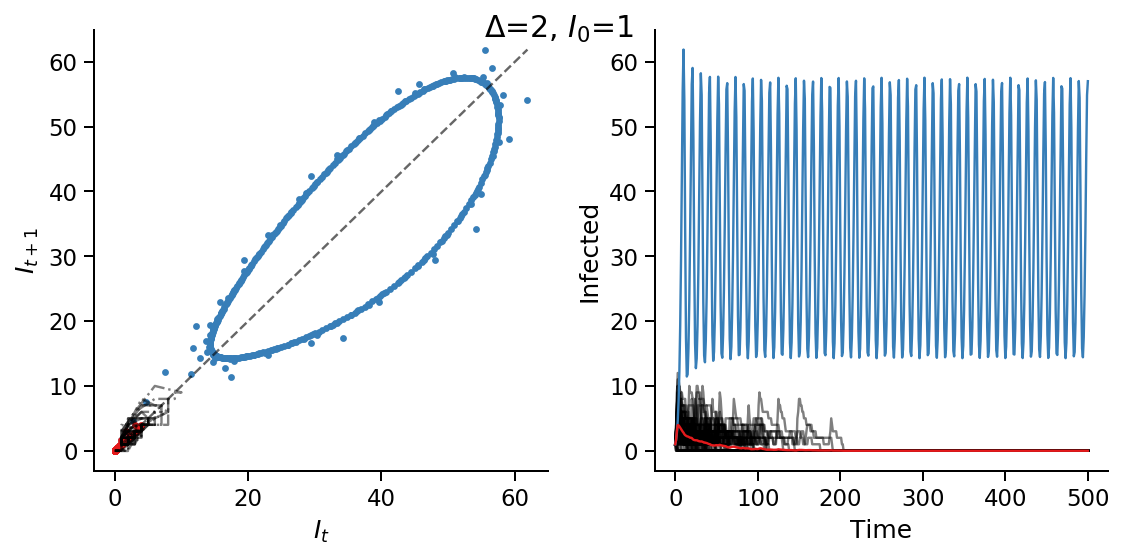

In [89]:
Δ_ = 2

EI = simulation(1, N, b0, γ, c_hat, α1, α2, Δ_)
I = multissimulation(1, N, b0, γ, c_hat, α1, α2, Δ_)
Ibar = I.mean(axis=0)

multiplot()
plt.suptitle("$\Delta$=2, $I_0$=1");

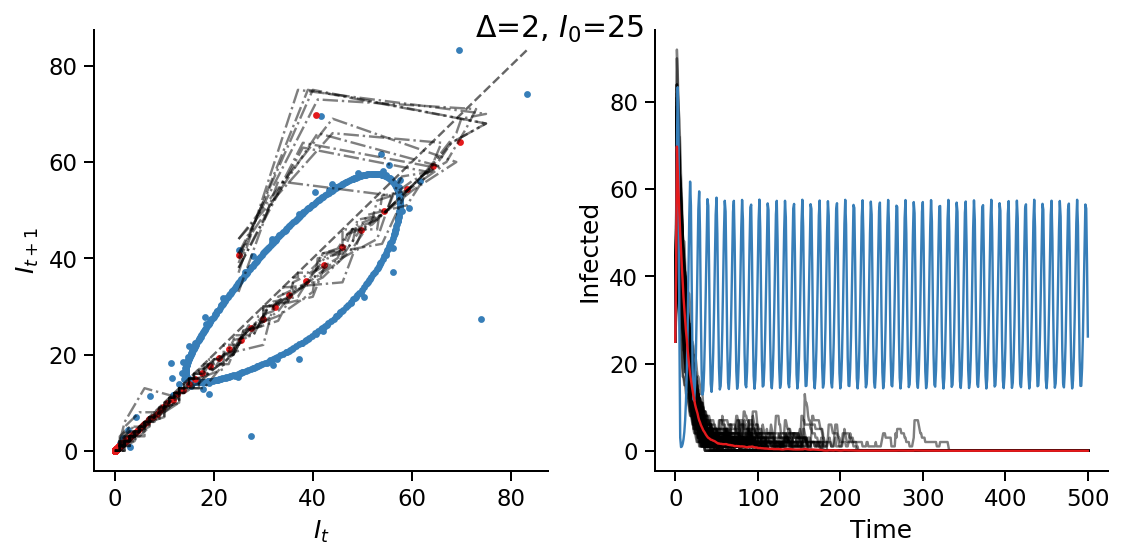

In [90]:
Δ_ = 2

EI = simulation(25, N, b0, γ, c_hat, α1, α2, Δ_)
I = multissimulation(25, N, b0, γ, c_hat, α1, α2, Δ_)
Ibar = I.mean(axis=0)

multiplot()
plt.suptitle("$\Delta$=2, $I_0$=25");

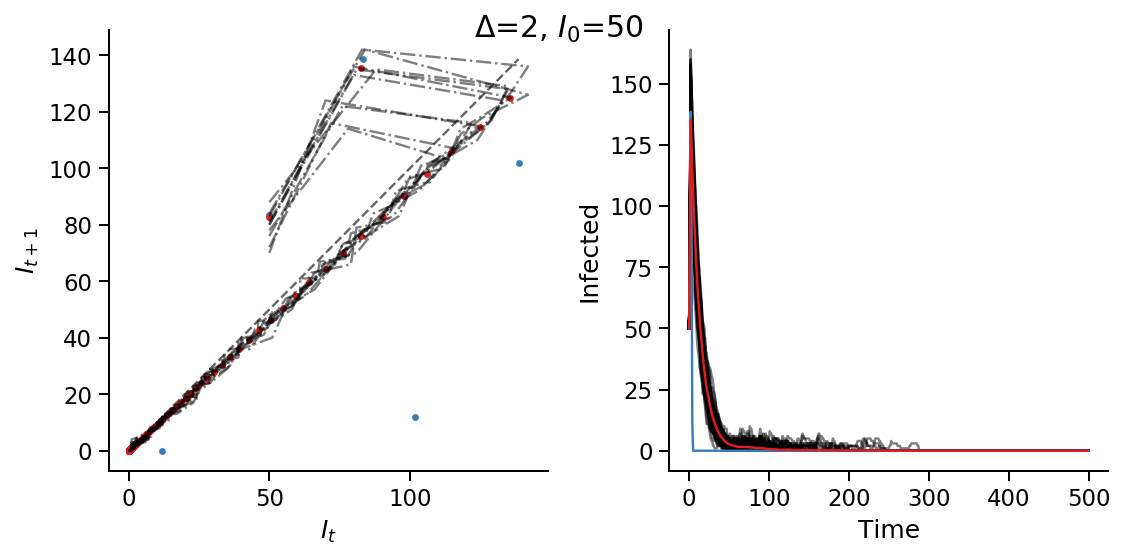

In [91]:
Δ_ = 2

EI = simulation(50, N, b0, γ, c_hat, α1, α2, Δ_)
I = multissimulation(50, N, b0, γ, c_hat, α1, α2, Δ_)
Ibar = I.mean(axis=0)

multiplot()
plt.suptitle("$\Delta$=2, $I_0$=50");